[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lweitkamp/GANs-JAX/blob/main/1_GANs.ipynb)


# Generative Adversarial Networks (GANs)

This notebook is based primarily on two papers. The first is the <a href="https://papers.nips.cc/paper/2014/file/5ca3e9b122f61f8f06494c97b1afccf3-Paper.pdf">original paper</a> on GANs (not counting Schmidhuber), the <a href="https://arxiv.org/abs/1511.06434">second paper</a> outlines improvements for training GANs and investigates the features learned by the generator for downstream tasks.


In the GAN setup, we want to implicity model a data distribution $p_{\text{data}}(x)$. The generator (G) is in charge of modelling $p_\text{data}$ through $p_g(x)$, and the discriminator (D) is in charge discerning data samples from the two distributions by a classification: 1 if the data is sampled from $p_{\text{data}}$ and 0 otherwise.


Formally this can be captured in a value function $V(D, G)$, where the generator and discriminator play the following minimax game:

$$
\large{
\underset{G}{\min} \underset{D}{\max} V(D, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_z(z)}[\log (1 - D(G(z)))]
}
$$


GAN training is notoriously difficult, the following problems are typically prevalent:

1. Mode Collapse: The generator learns a specific subset of the data distribution (a mode), and the discriminator learns to classify these as false. The generator loops to a new mode and the problem continues.
2. <a href="https://arxiv.org/pdf/1701.04862.pdf">Vanishing Gradients</a>: If the discriminator converges too quickly, the signal back to the generator can be significantly small such that training is impossible for the generator. 
3. Random issues with convergence; both papers outline ways to combat these, for example label smoothing, batch-norm, tweaking the loss function for the generator, etc.

In [1]:
%%capture
!pip install --upgrade -q flax

In [2]:
# Run it on a TPU (if possible)!
import jax.tools.colab_tpu
try:
  jax.tools.colab_tpu.setup_tpu()
except:
  pass

In [3]:
import os
from functools import partial

import jax
import jax.numpy as jnp
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.1'

from typing import Any, Tuple


PRNGKey = jnp.ndarray


num_devices = jax.device_count()

args = {
    'z_dim': 64,
    'seed': 41,
}

# Set the parallel batch size.
args['batch_size'] = num_devices * 256 if num_devices > 1 else 256
args['epochs'] = 100
args['batch_size_p'] = args['batch_size'] //  num_devices

args['true_label'] = jnp.ones((args['batch_size_p'], 1), dtype=jnp.int32)
args['false_label'] = jnp.zeros((args['batch_size_p'], 1), dtype=jnp.int32)

os.makedirs(os.path.join("results", "1_GAN"), exist_ok=True)

## Loading MNIST

In [4]:
import tensorflow_datasets as tfds
import tensorflow as tf


def set_range(batch):
  batch = tf.image.convert_image_dtype(batch['image'], tf.float32)
  batch = (batch - 0.5) / 0.5  # tanh range is -1, 1
  return batch
 

mnist_data = tfds.load("mnist")['train']
batches_in_epoch = len(mnist_data) // args['batch_size']
 
data_gen = iter(tfds.as_numpy(
      mnist_data
        .map(set_range)
        .cache()
        .shuffle(len(mnist_data), seed=args['seed'])
        .repeat()
        .batch(args['batch_size'])
 ))

2022-11-27 16:43:38.417614: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-27 16:43:38.783274: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/trent
2022-11-27 16:43:38.783305: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/trent
2022-11-27 16:43:38.783308: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Flax Linen Architecture

In [5]:
from jax.nn.initializers import normal as normal_init
from flax.training import train_state
from flax import linen as nn


class TrainState(train_state.TrainState):
  batch_stats: Any


class Generator(nn.Module):
  features: int = 64
  dtype: type = jnp.float32

  @nn.compact
  def __call__(self, z: jnp.ndarray, train: bool = True):
    conv_transpose = partial(nn.ConvTranspose, padding='VALID',
                             kernel_init=normal_init(0.02), dtype=self.dtype)
    batch_norm = partial(nn.BatchNorm, use_running_average=not train, axis=-1, 
                         scale_init=normal_init(0.02), dtype=self.dtype)

    z = z.reshape((args['batch_size_p'], 1, 1, args['z_dim']))
    x = conv_transpose(self.features*4, kernel_size=[3, 3], strides=[2, 2])(z)
    x = batch_norm()(x)
    x = nn.relu(x)
    x = conv_transpose(self.features*4, kernel_size=[4, 4], strides=[1, 1])(x)
    x = batch_norm()(x)
    x = nn.relu(x)
    x = conv_transpose(self.features*2, kernel_size=[3, 3], strides=[2, 2])(x)
    x = batch_norm()(x)
    x = nn.relu(x)
    x = conv_transpose(1, [4, 4], [2, 2])(x)
    x = jnp.tanh(x)
    return x


class Discriminator(nn.Module):
  features: int = 64
  dtype: Any = jnp.float32

  @nn.compact
  def __call__(self, x: jnp.ndarray, train: bool = True):
    conv = partial(nn.Conv, kernel_size=[4, 4], strides=[2, 2], padding='VALID',
                   kernel_init=normal_init(0.02), dtype=self.dtype)
    batch_norm = partial(nn.BatchNorm, use_running_average=not train, axis=-1,
                         scale_init=normal_init(0.02), dtype=self.dtype)
        
    x = conv(self.features)(x)
    x = batch_norm()(x)
    x = nn.leaky_relu(x, 0.2)
    x = conv(self.features*2)(x)
    x = batch_norm()(x)
    x = nn.leaky_relu(x, 0.2)
    x = conv(1)(x)
    x = x.reshape((args['batch_size_p'], -1))
    return x

## GAN Loss Function

In [6]:
import optax


@partial(jax.pmap, axis_name='num_devices')
def generator_step(generator_state: TrainState,
                   discriminator_state: TrainState,
                   key: PRNGKey):
  r"""The generator is updated by generating data and letting the discriminator
  critique it. It's loss goes down if the discriminator wrongly predicts it to
  to be real data."""
  input_noise = jax.random.normal(key, (args['batch_size_p'], args['z_dim']))

  def loss_fn(params):
    generated_data, mutables = generator_state.apply_fn(
        {'params': params, 'batch_stats': generator_state.batch_stats},
        input_noise, mutable=['batch_stats'])
    
    logits, _ = discriminator_state.apply_fn(
        {'params': discriminator_state.params, 
         'batch_stats': discriminator_state.batch_stats},
         generated_data, mutable=['batch_stats'])
    
    loss = -jnp.mean(jnp.log(nn.sigmoid(logits)))
    return loss, mutables
  
  # Generate data with the Generator, critique it with the Discriminator.
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, mutables), grads = grad_fn(generator_state.params)

  # Average across the devices.
  grads = jax.lax.pmean(grads, axis_name='num_devices')
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  # Update the Generator through gradient descent.
  new_generator_state = generator_state.apply_gradients(
      grads=grads, batch_stats=mutables['batch_stats'])
  
  return new_generator_state, loss


@partial(jax.pmap, axis_name='num_devices')
def discriminator_step(generator_state: TrainState,
                       discriminator_state: TrainState,
                       real_data: jnp.ndarray,
                       key: PRNGKey):
  r"""The discriminator is updated by critiquing both real and generated data,
  It's loss goes down as it predicts correctly if images are real or generated.
  """
  input_noise = jax.random.normal(key, (args['batch_size_p'], args['z_dim']))

  generated_data, _ = generator_state.apply_fn(
        {'params': generator_state.params, 
         'batch_stats': generator_state.batch_stats},
         input_noise, mutable=['batch_stats'])
  
  def loss_fn(params):
    logits_real, mutables = discriminator_state.apply_fn(
        {'params': params, 'batch_stats': discriminator_state.batch_stats},
        real_data, mutable=['batch_stats'])
        
    logits_generated, mutables = discriminator_state.apply_fn(
        {'params': params, 'batch_stats': mutables['batch_stats']},
        generated_data, mutable=['batch_stats'])
    
    real_loss = optax.sigmoid_binary_cross_entropy(
        logits_real, args['true_label']).mean()
    generated_loss = optax.sigmoid_binary_cross_entropy(
        logits_generated, args['false_label']).mean()
    
    loss = (real_loss + generated_loss) / 2

    return loss, mutables

  # Critique real and generated data with the Discriminator.
  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, mutables), grads = grad_fn(discriminator_state.params)

  # Average cross the devices.
  grads = jax.lax.pmean(grads, axis_name='num_devices')
  loss = jax.lax.pmean(loss, axis_name='num_devices')

  # Update the discriminator through gradient descent.
  new_discriminator_state = discriminator_state.apply_gradients(
      grads=grads, batch_stats=mutables['batch_stats'])
  
  return new_discriminator_state, loss

## Helper Functions

In [7]:
@partial(jax.pmap, static_broadcasted_argnums=(1, 2))
def create_state(rng, model_cls, input_shape): 
  r"""Create the training state given a model class. """ 
  model = model_cls()

  tx = optax.adam(0.0002, b1=0.5, b2=0.999)
  variables = model.init(rng, jnp.ones(input_shape))

  state = TrainState.create(apply_fn=model.apply, tx=tx, 
      params=variables['params'], batch_stats=variables['batch_stats'])
  
  return state


@jax.pmap
def sample_from_generator(generator_state, input_noise):
  """Sample from the generator in evaluation mode."""
  generated_data = generator_state.apply_fn(
      {'params': generator_state.params,
       'batch_stats': generator_state.batch_stats},
      input_noise, train=False, mutable=False)
  return generated_data

## Training

In [8]:
from flax.training.common_utils import shard, shard_prng_key


key = jax.random.PRNGKey(seed=args['seed'])
key_generator, key_discriminator, key = jax.random.split(key, 3)
key_generator = shard_prng_key(key_generator)
key_discriminator = shard_prng_key(key_discriminator)

discriminator_state = create_state(key_discriminator, Discriminator, 
    (args['batch_size_p'], *next(data_gen).shape[1:]))

generator_state = create_state(key_generator, Generator, 
    (args['batch_size_p'], args['z_dim']))

generator_input = jax.random.normal(key, (args['batch_size'], args['z_dim']))
generator_input = shard(generator_input)

In [9]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


for epoch in tqdm(range(1, args['epochs'] + 1), desc="Epoch...",
                  position=0, leave=True):
  
  with tqdm(total=batches_in_epoch, desc="Training...",
            leave=False) as progress_bar_train:
    for batch in range(batches_in_epoch):

      # Generate RNG keys for generator and discriminator.
      key, key_generator, key_discriminator = jax.random.split(key, 3)
      key_generator = shard_prng_key(key_generator)
      key_discriminator = shard_prng_key(key_discriminator)

      # Shard the data to possible devices.
      batch_data = shard(next(data_gen))

      # Take a step with the generator.
      generator_state, generator_loss = generator_step(generator_state, 
          discriminator_state, key_generator)

      # Take a step with the discriminator.
      discriminator_state, discriminator_loss = discriminator_step(
          generator_state, discriminator_state, batch_data, key_discriminator)

      progress_bar_train.update(1)
    
    metrics = jax.device_get([generator_loss[0], discriminator_loss[1]])

    message = f"Epoch: {epoch: <2} | "
    message += f"Generator loss: {metrics[0]:.3f} | "
    message += f"Discriminator loss: {metrics[1]:.3f}"
    progress_bar_train.write(message)

  # Sample from the generator using the fixed input. We need to
  # reshape if we are working on multiple devices.
  sample = sample_from_generator(generator_state, generator_input)
  sample = sample.reshape((-1, 28, 28))

  # Next, plot the static samples, save the fig to disk.
  if epoch % 10 == 0:
    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    for ax, image in zip(sum(axes.tolist(), []), sample):
      ax.imshow(image, cmap='gray')
      ax.set_axis_off()
    fig.savefig(f"results/1_GAN/GAN_epoch_{epoch}.png")
    plt.close(fig)

Epoch...:   0%|          | 0/100 [00:00<?, ?it/s]

Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 1  | Generator loss: 1.316 | Discriminator loss: 0.372


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 2  | Generator loss: 2.725 | Discriminator loss: 0.091


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 3  | Generator loss: 3.696 | Discriminator loss: 0.036


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 4  | Generator loss: 4.656 | Discriminator loss: 0.016


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 5  | Generator loss: 1.945 | Discriminator loss: 0.252


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 6  | Generator loss: 1.358 | Discriminator loss: 0.367


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 7  | Generator loss: 1.150 | Discriminator loss: 0.318


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 8  | Generator loss: 1.359 | Discriminator loss: 0.452


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 9  | Generator loss: 1.090 | Discriminator loss: 0.593


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 10 | Generator loss: 1.652 | Discriminator loss: 0.457


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 11 | Generator loss: 0.850 | Discriminator loss: 0.496


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 12 | Generator loss: 0.836 | Discriminator loss: 0.524


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 13 | Generator loss: 0.756 | Discriminator loss: 0.532


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 14 | Generator loss: 1.028 | Discriminator loss: 0.555


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 15 | Generator loss: 0.584 | Discriminator loss: 0.625


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 16 | Generator loss: 0.547 | Discriminator loss: 0.613


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 17 | Generator loss: 0.729 | Discriminator loss: 0.547


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 18 | Generator loss: 0.963 | Discriminator loss: 0.566


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 19 | Generator loss: 0.932 | Discriminator loss: 0.580


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 20 | Generator loss: 1.365 | Discriminator loss: 0.551


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 21 | Generator loss: 1.073 | Discriminator loss: 0.551


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 22 | Generator loss: 0.914 | Discriminator loss: 0.572


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 23 | Generator loss: 0.964 | Discriminator loss: 0.586


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 24 | Generator loss: 0.993 | Discriminator loss: 0.564


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 25 | Generator loss: 0.916 | Discriminator loss: 0.559


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 26 | Generator loss: 1.013 | Discriminator loss: 0.572


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 27 | Generator loss: 1.019 | Discriminator loss: 0.587


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 28 | Generator loss: 0.952 | Discriminator loss: 0.569


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 29 | Generator loss: 0.930 | Discriminator loss: 0.656


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 30 | Generator loss: 0.898 | Discriminator loss: 0.596


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 31 | Generator loss: 1.038 | Discriminator loss: 0.586


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 32 | Generator loss: 1.129 | Discriminator loss: 0.601


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 33 | Generator loss: 1.010 | Discriminator loss: 0.628


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 34 | Generator loss: 1.034 | Discriminator loss: 0.593


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 35 | Generator loss: 0.882 | Discriminator loss: 0.579


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 36 | Generator loss: 0.909 | Discriminator loss: 0.734


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 37 | Generator loss: 1.068 | Discriminator loss: 0.619


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 38 | Generator loss: 0.793 | Discriminator loss: 0.596


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 39 | Generator loss: 0.929 | Discriminator loss: 0.596


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 40 | Generator loss: 0.959 | Discriminator loss: 0.585


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 41 | Generator loss: 1.015 | Discriminator loss: 0.564


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 42 | Generator loss: 0.838 | Discriminator loss: 0.587


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 43 | Generator loss: 1.132 | Discriminator loss: 0.687


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 44 | Generator loss: 0.692 | Discriminator loss: 0.662


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 45 | Generator loss: 0.947 | Discriminator loss: 0.616


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 46 | Generator loss: 0.805 | Discriminator loss: 0.617


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 47 | Generator loss: 0.939 | Discriminator loss: 0.623


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 48 | Generator loss: 0.890 | Discriminator loss: 0.654


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 49 | Generator loss: 1.055 | Discriminator loss: 0.627


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 50 | Generator loss: 0.825 | Discriminator loss: 0.623


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 51 | Generator loss: 0.770 | Discriminator loss: 0.657


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 52 | Generator loss: 0.873 | Discriminator loss: 0.687


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 53 | Generator loss: 0.811 | Discriminator loss: 0.646


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 54 | Generator loss: 0.764 | Discriminator loss: 0.645


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 55 | Generator loss: 0.834 | Discriminator loss: 0.651


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 56 | Generator loss: 0.763 | Discriminator loss: 0.633


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 57 | Generator loss: 1.015 | Discriminator loss: 0.675


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 58 | Generator loss: 1.054 | Discriminator loss: 0.651


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 59 | Generator loss: 0.794 | Discriminator loss: 0.648


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 60 | Generator loss: 0.598 | Discriminator loss: 0.669


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 61 | Generator loss: 0.687 | Discriminator loss: 0.656


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 62 | Generator loss: 0.838 | Discriminator loss: 0.627


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 63 | Generator loss: 0.791 | Discriminator loss: 0.656


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 64 | Generator loss: 0.868 | Discriminator loss: 0.658


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 65 | Generator loss: 0.684 | Discriminator loss: 0.675


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 66 | Generator loss: 0.768 | Discriminator loss: 0.673


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 67 | Generator loss: 0.742 | Discriminator loss: 0.652


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 68 | Generator loss: 0.847 | Discriminator loss: 0.657


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 69 | Generator loss: 0.698 | Discriminator loss: 0.663


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 70 | Generator loss: 0.797 | Discriminator loss: 0.670


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 71 | Generator loss: 0.799 | Discriminator loss: 0.718


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 72 | Generator loss: 0.661 | Discriminator loss: 0.653


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 73 | Generator loss: 0.786 | Discriminator loss: 0.653


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 74 | Generator loss: 0.743 | Discriminator loss: 0.649


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 75 | Generator loss: 1.325 | Discriminator loss: 0.745


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 76 | Generator loss: 1.133 | Discriminator loss: 0.679


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 77 | Generator loss: 0.490 | Discriminator loss: 0.731


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 78 | Generator loss: 0.824 | Discriminator loss: 0.648


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 79 | Generator loss: 0.688 | Discriminator loss: 0.680


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 80 | Generator loss: 0.703 | Discriminator loss: 0.666


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 81 | Generator loss: 0.427 | Discriminator loss: 0.740


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 82 | Generator loss: 0.602 | Discriminator loss: 0.679


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 83 | Generator loss: 0.807 | Discriminator loss: 0.680


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 84 | Generator loss: 0.713 | Discriminator loss: 0.646


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 85 | Generator loss: 0.794 | Discriminator loss: 0.678


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 86 | Generator loss: 0.763 | Discriminator loss: 0.665


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 87 | Generator loss: 0.710 | Discriminator loss: 0.690


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 88 | Generator loss: 0.761 | Discriminator loss: 0.675


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 89 | Generator loss: 0.782 | Discriminator loss: 0.674


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 90 | Generator loss: 0.723 | Discriminator loss: 0.658


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 91 | Generator loss: 0.777 | Discriminator loss: 0.693


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 92 | Generator loss: 0.773 | Discriminator loss: 0.670


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 93 | Generator loss: 0.892 | Discriminator loss: 0.690


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 94 | Generator loss: 0.762 | Discriminator loss: 0.676


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 95 | Generator loss: 0.731 | Discriminator loss: 0.688


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 96 | Generator loss: 0.723 | Discriminator loss: 0.674


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 97 | Generator loss: 0.654 | Discriminator loss: 0.683


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 98 | Generator loss: 0.786 | Discriminator loss: 0.683


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 99 | Generator loss: 0.778 | Discriminator loss: 0.668


Training...:   0%|          | 0/234 [00:00<?, ?it/s]

Epoch: 100 | Generator loss: 0.862 | Discriminator loss: 0.678


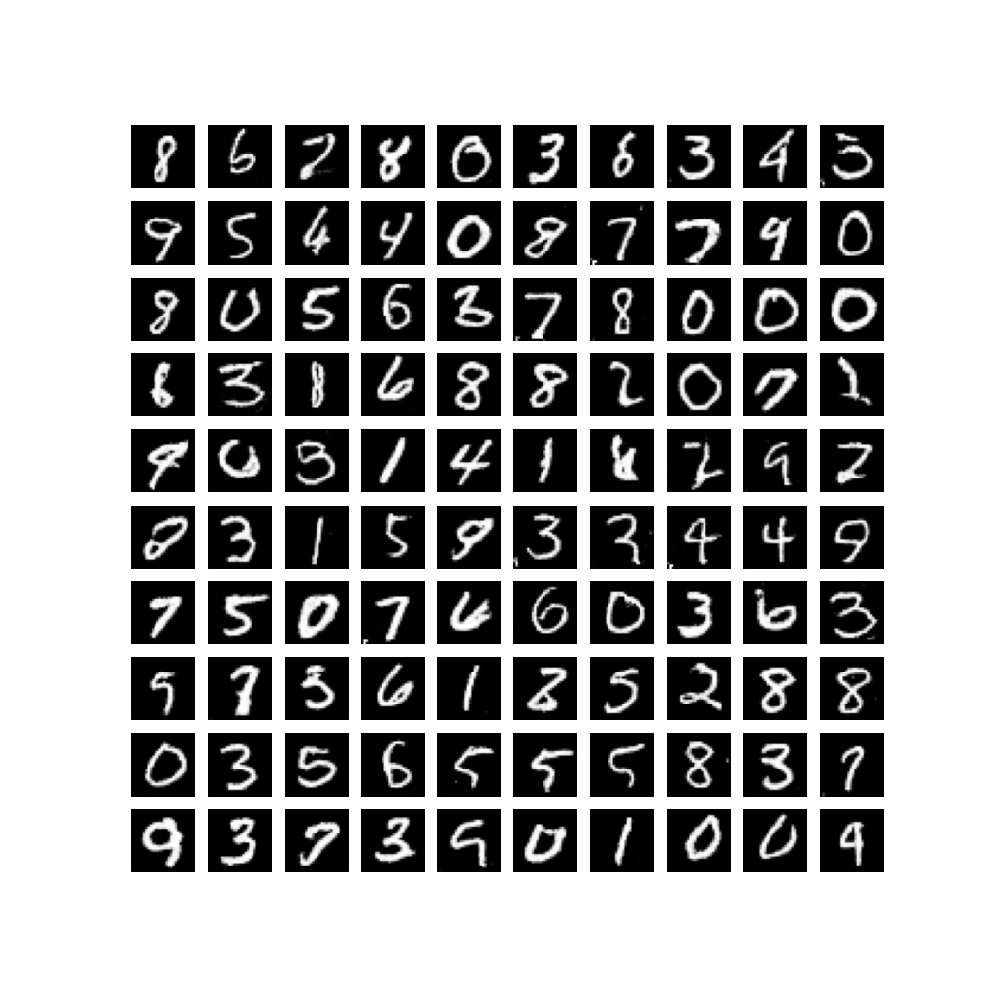

In [14]:
import matplotlib.image as mpimg

# Load latest epoch results.
img = mpimg.imread(os.path.join('results', '1_GAN', f'GAN_epoch_{100}.png'))


fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img, interpolation='nearest')
plt.axis('off')
plt.tight_layout()
plt.show()